In [39]:
from pathlib import Path
import re

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
    import jinja2  # noqa: F401
    HAS_JINJA = True
except ModuleNotFoundError:
    HAS_JINJA = False

# Define both log files - updated paths
LOG_FILES = {
    "Individual Ops": Path("../output/ffn.log"),
    "Fused Ops": Path("../output/ffn_fused.log")
}

# Check that all log files exist
for log_type, log_path in LOG_FILES.items():
    if not log_path.exists():
        raise FileNotFoundError(f"Expected {log_type} log at {log_path.resolve()}")

sns.set_theme(style="whitegrid")


In [40]:
def parse_gemmini_log(log_text, log_type="Individual Ops"):
    """Parse Gemmini FFN benchmark logs into structured rows per operation."""
    op_header_re = re.compile(r"-- Counter Stats for \[(?P<operation>.+?)\] --")
    kv_regex = re.compile(r"^\s*([A-Z_]+):\s+(\d+)")

    # Handle both individual and fused model metadata patterns
    model_meta_re = re.compile(
        r"(?P<model>[\w-]+)\s+(?:FUSED\s+)?FFN stats:\s*hidden_dim=(?P<hidden>\d+),\s*expansion_dim=(?P<expansion>\d+),\s*seq_len=(?P<seq>\d+)(?:,\s*tile_size=(?P<tile>\d+))?",
        re.IGNORECASE,
    )
    cpu_line_re = re.compile(
        r"(?P<model>[\w-]+)\s+(?:FUSED\s+)?FFN\s+(?:\(tile_size=(?P<tile>\d+)\)\s+)?total CPU cycles:\s*(?P<cpu>\d+)",
        re.IGNORECASE,
    )

    data = []
    current_ops = []
    current_op = None
    meta = {}

    for line in log_text.splitlines():
        header_match = op_header_re.search(line)
        if header_match:
            current_op = {"Operation": header_match.group("operation").strip()}
            current_ops.append(current_op)
            continue

        if current_op:
            kv_match = kv_regex.match(line)
            if kv_match:
                key, value = kv_match.groups()
                current_ops[-1][key] = int(value)
                continue

            if line.strip().startswith("--------------------------------"):
                current_op = None
            continue

        meta_match = model_meta_re.match(line)
        if meta_match:
            meta = {
                "Model": meta_match.group("model"),
                "HIDDEN_DIM": int(meta_match.group("hidden")),
                "EXPANSION_DIM": int(meta_match.group("expansion")),
                "SEQ_LEN": int(meta_match.group("seq")),
                "TILE_SIZE": int(meta_match.group("tile")) if meta_match.group("tile") else None,
                "Log_Type": log_type,
            }
            continue

        cpu_match = cpu_line_re.match(line)
        if cpu_match and meta:
            cpu_cycles = int(cpu_match.group("cpu"))
            # Update tile_size if found in CPU line (takes precedence)
            if cpu_match.group("tile"):
                meta["TILE_SIZE"] = int(cpu_match.group("tile"))

            if not current_ops:
                meta = {}
                continue

            for op_entry in current_ops:
                data.append({
                    **op_entry,
                    **meta,
                    "CPU_TOTAL_CYCLES": cpu_cycles,
                })

            current_ops = []
            current_op = None
            meta = {}

    if current_ops and meta:
        # Handle case where log ends without CPU cycle summary
        for op_entry in current_ops:
            data.append({
                **op_entry,
                **meta,
                "CPU_TOTAL_CYCLES": 0,  # Default if not found
            })

    return data

# Parse both log files
all_data = []
for log_type, log_path in LOG_FILES.items():
    log_data = log_path.read_text()
    parsed_data = parse_gemmini_log(log_data, log_type)
    all_data.extend(parsed_data)

if not all_data:
    raise ValueError("No benchmark data extracted from any log files.")

df = pd.DataFrame(all_data)

## Data Summary

Let's first examine the parsed data from both log files:

In [41]:
# Display basic information about the parsed data
print(f"Total rows parsed: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nLog types: {df['Log_Type'].unique()}")
print(f"\nModels: {df['Model'].unique()}")
print(f"\nOperations: {df['Operation'].unique()}")

# Show first few rows
print("\n" + "="*80)
print("Sample of parsed data:")
display(df.head(10))

Total rows parsed: 16

Columns: ['Operation', 'LOAD_ACTIVE_CYCLE', 'STORE_ACTIVE_CYCLE', 'EXE_ACTIVE_CYCLE', 'LOAD_DMA_WAIT_CYCLE', 'EXE_PRELOAD_HAZ_CYCLE', 'MAIN_LD_ST_EX_CYCLES', 'Model', 'HIDDEN_DIM', 'EXPANSION_DIM', 'SEQ_LEN', 'TILE_SIZE', 'Log_Type', 'CPU_TOTAL_CYCLES']

Log types: ['Individual Ops' 'Fused Ops']

Models: ['bert-base' 'bert-large']

Operations: ['Matmul1+GELU' 'Matmul2' 'LayerNorm' 'ResAdd' 'Entire Fused FFN']

Sample of parsed data:


,Operation,LOAD_ACTIVE_CYCLE,STORE_ACTIVE_CYCLE,EXE_ACTIVE_CYCLE,LOAD_DMA_WAIT_CYCLE,EXE_PRELOAD_HAZ_CYCLE,MAIN_LD_ST_EX_CYCLES,Model,HIDDEN_DIM,EXPANSION_DIM,SEQ_LEN,TILE_SIZE,Log_Type,CPU_TOTAL_CYCLES
0,Matmul1+GELU,119623,118682,119788,116971,121762,123743,bert-base,768,3072,128,NaN,Individual Ops,445000
1,Matmul2,122664,126144,125624,123632,123671,124121,bert-base,768,3072,128,NaN,Individual Ops,445000
2,LayerNorm,1371994,1371324,1383082,1340361,1365151,1389863,bert-base,768,3072,128,NaN,Individual Ops,445000
3,ResAdd,20233,18032,19864,19300,22746,19919,bert-base,768,3072,128,NaN,Individual Ops,445000
4,Matmul1+GELU,631848,647381,649765,642736,646189,637135,bert-large,1024,4096,256,NaN,Individual Ops,715001
5,Matmul2,476593,483783,489502,478096,473487,480463,bert-large,1024,4096,256,NaN,Individual Ops,715001
6,LayerNorm,3603137,3569576,3641607,3611958,3581950,3595792,bert-large,1024,4096,256,NaN,Individual Ops,715001
7,ResAdd,50148,49273,50811,54247,53288,50727,bert-large,1024,4096,256,NaN,Individual Ops,715001
8,Entire Fused FFN,1995752,2000196,2015005,1965884,1997326,2018432,bert-base,768,3072,128,16.0,Fused Ops,275000
9,Entire Fused FFN,1727811,1721585,1747671,1727022,1712264,1731320,bert-base,768,3072,128,32.0,Fused Ops,250000


## Calculate Unit Utilization and Duty Cycles

We'll calculate the following metrics:
- **Execute Unit Utilization**: Percentage of time the execution unit is actually computing
- **Load Unit Duty Cycle**: Percentage of time the load unit is active
- **Store Unit Duty Cycle**: Percentage of time the store unit is active
- **Pipeline Overlap Efficiency**: Percentage of time all 3 units are working together

In [42]:
# Calculate utilization metrics
def calculate_utilization_metrics(row):
    """Calculate various utilization and efficiency metrics."""
    total_cycles = row['CPU_TOTAL_CYCLES']

    if total_cycles == 0:
        return pd.Series({
            'Load_Duty_Cycle_%': 0,
            'Store_Duty_Cycle_%': 0,
            'Exec_Duty_Cycle_%': 0,
            'Pipeline_Overlap_%': 0,
            'Load_DMA_Wait_%': 0,
            'Exec_Preload_Stall_%': 0
        })

    metrics = {
        'Load_Duty_Cycle_%': (row['LOAD_ACTIVE_CYCLE'] / total_cycles) * 100,
        'Store_Duty_Cycle_%': (row['STORE_ACTIVE_CYCLE'] / total_cycles) * 100,
        'Exec_Duty_Cycle_%': (row['EXE_ACTIVE_CYCLE'] / total_cycles) * 100,
        'Pipeline_Overlap_%': (row['MAIN_LD_ST_EX_CYCLES'] / total_cycles) * 100,
        'Load_DMA_Wait_%': (row['LOAD_DMA_WAIT_CYCLE'] / total_cycles) * 100,
        'Exec_Preload_Stall_%': (row['EXE_PRELOAD_HAZ_CYCLE'] / total_cycles) * 100
    }

    return pd.Series(metrics)

# Apply calculations
utilization_metrics = df.apply(calculate_utilization_metrics, axis=1)
df = pd.concat([df, utilization_metrics], axis=1)

print("Utilization metrics calculated successfully!")

Utilization metrics calculated successfully!


## Comparison Table: Fused vs Non-Fused

Summary comparing fused (with different tiling parameters) and non-fused executions:

In [43]:
# Create comparison table
# For fused operations, aggregate by model and tile size
# For non-fused, aggregate all operations per model

def create_comparison_table(df):
    comparison_data = []

    # Process fused operations (one entry per model/tile combination)
    fused_df = df[df['Log_Type'] == 'Fused Ops'].copy()
    for _, row in fused_df.iterrows():
        tile_info = f"tile={row['TILE_SIZE']}" if pd.notna(row['TILE_SIZE']) else "N/A"
        comparison_data.append({
            'Model': row['Model'],
            'Type': f'Fused ({tile_info})',
            'Total_CPU_Cycles': row['CPU_TOTAL_CYCLES'],
            'Total_Load_Active': row['LOAD_ACTIVE_CYCLE'],
            'Total_Store_Active': row['STORE_ACTIVE_CYCLE'],
            'Total_Exec_Active': row['EXE_ACTIVE_CYCLE'],
            'Total_Pipeline_Overlap': row['MAIN_LD_ST_EX_CYCLES'],
            'Avg_Load_Duty_%': row['Load_Duty_Cycle_%'],
            'Avg_Store_Duty_%': row['Store_Duty_Cycle_%'],
            'Avg_Exec_Duty_%': row['Exec_Duty_Cycle_%'],
            'Avg_Pipeline_Overlap_%': row['Pipeline_Overlap_%'],
            'Avg_DMA_Wait_%': row['Load_DMA_Wait_%'],
            'Avg_Exec_Stall_%': row['Exec_Preload_Stall_%'],
        })

    # Process non-fused operations (sum all operations per model)
    non_fused_df = df[df['Log_Type'] == 'Individual Ops'].copy()
    for model in non_fused_df['Model'].unique():
        model_df = non_fused_df[non_fused_df['Model'] == model]

        # Get the total CPU cycles (should be same for all rows of same model)
        total_cpu = model_df['CPU_TOTAL_CYCLES'].iloc[0]

        comparison_data.append({
            'Model': model,
            'Type': 'Non-Fused',
            'Total_CPU_Cycles': total_cpu,
            'Total_Load_Active': model_df['LOAD_ACTIVE_CYCLE'].sum(),
            'Total_Store_Active': model_df['STORE_ACTIVE_CYCLE'].sum(),
            'Total_Exec_Active': model_df['EXE_ACTIVE_CYCLE'].sum(),
            'Total_Pipeline_Overlap': model_df['MAIN_LD_ST_EX_CYCLES'].sum(),
            'Avg_Load_Duty_%': model_df['Load_Duty_Cycle_%'].mean(),
            'Avg_Store_Duty_%': model_df['Store_Duty_Cycle_%'].mean(),
            'Avg_Exec_Duty_%': model_df['Exec_Duty_Cycle_%'].mean(),
            'Avg_Pipeline_Overlap_%': model_df['Pipeline_Overlap_%'].mean(),
            'Avg_DMA_Wait_%': model_df['Load_DMA_Wait_%'].mean(),
            'Avg_Exec_Stall_%': model_df['Exec_Preload_Stall_%'].mean(),
        })

    return pd.DataFrame(comparison_data)

comparison_table = create_comparison_table(df)

# Sort by model and type
comparison_table = comparison_table.sort_values(['Model', 'Type'])

print("="*120)
print("COMPARISON TABLE: FUSED vs NON-FUSED")
print("="*120)
display(comparison_table)

# Calculate speedup
print("\n" + "="*120)
print("SPEEDUP ANALYSIS")
print("="*120)
for model in comparison_table['Model'].unique():
    model_data = comparison_table[comparison_table['Model'] == model]
    non_fused_cycles = model_data[model_data['Type'] == 'Non-Fused']['Total_CPU_Cycles'].values[0]

    print(f"\n{model}:")
    print(f"  Non-Fused: {non_fused_cycles:,} cycles")

    fused_data = model_data[model_data['Type'].str.startswith('Fused')]
    for _, row in fused_data.iterrows():
        speedup = non_fused_cycles / row['Total_CPU_Cycles']
        print(f"  {row['Type']}: {row['Total_CPU_Cycles']:,} cycles (Speedup: {speedup:.2f}x)")

COMPARISON TABLE: FUSED vs NON-FUSED


,Model,Type,Total_CPU_Cycles,Total_Load_Active,Total_Store_Active,Total_Exec_Active,Total_Pipeline_Overlap,Avg_Load_Duty_%,Avg_Store_Duty_%,Avg_Exec_Duty_%,Avg_Pipeline_Overlap_%,Avg_DMA_Wait_%,Avg_Exec_Stall_%
3,bert-base,Fused (tile=128.0),240000,1641127,1642483,1648884,1649596,683.802917,684.367917,687.035000,687.331667,687.660000,682.696250
0,bert-base,Fused (tile=16.0),275000,1995752,2000196,2015005,2018432,725.728000,727.344000,732.729091,733.975273,714.866909,726.300364
1,bert-base,Fused (tile=32.0),250000,1727811,1721585,1747671,1731320,691.124400,688.634000,699.068400,692.528000,690.808800,684.905600
2,bert-base,Fused (tile=64.0),240000,1592260,1589257,1616695,1582427,663.441667,662.190417,673.622917,659.344583,667.998333,664.821667
8,bert-base,Non-Fused,445000,1634514,1634182,1648358,1657646,91.826629,91.807978,92.604382,93.126180,89.902472,91.760112
7,bert-large,Fused (tile=128.0),539999,4761231,4777369,4761028,4766013,881.711077,884.699601,881.673485,882.596634,881.682373,884.514601
4,bert-large,Fused (tile=16.0),675001,6261850,6294792,6246408,6294346,927.680107,932.560396,925.392407,932.494322,930.179955,929.534623
5,bert-large,Fused (tile=32.0),584999,5221573,5213439,5194943,5240801,892.578107,891.187677,888.025962,895.864950,887.224252,883.543903
6,bert-large,Fused (tile=64.0),530001,4620938,4609201,4621988,4648051,871.873449,869.658925,872.071562,876.989100,871.540808,870.245528
9,bert-large,Non-Fused,715001,4761726,4750013,4831685,4764117,166.493683,166.084138,168.939799,166.577285,167.378682,166.255502



SPEEDUP ANALYSIS

bert-base:
  Non-Fused: 445,000 cycles
  Fused (tile=128.0): 240,000 cycles (Speedup: 1.85x)
  Fused (tile=16.0): 275,000 cycles (Speedup: 1.62x)
  Fused (tile=32.0): 250,000 cycles (Speedup: 1.78x)
  Fused (tile=64.0): 240,000 cycles (Speedup: 1.85x)

bert-large:
  Non-Fused: 715,001 cycles
  Fused (tile=128.0): 539,999 cycles (Speedup: 1.32x)
  Fused (tile=16.0): 675,001 cycles (Speedup: 1.06x)
  Fused (tile=32.0): 584,999 cycles (Speedup: 1.22x)
  Fused (tile=64.0): 530,001 cycles (Speedup: 1.35x)


## Visualization: Fused vs Non-Fused Comparison

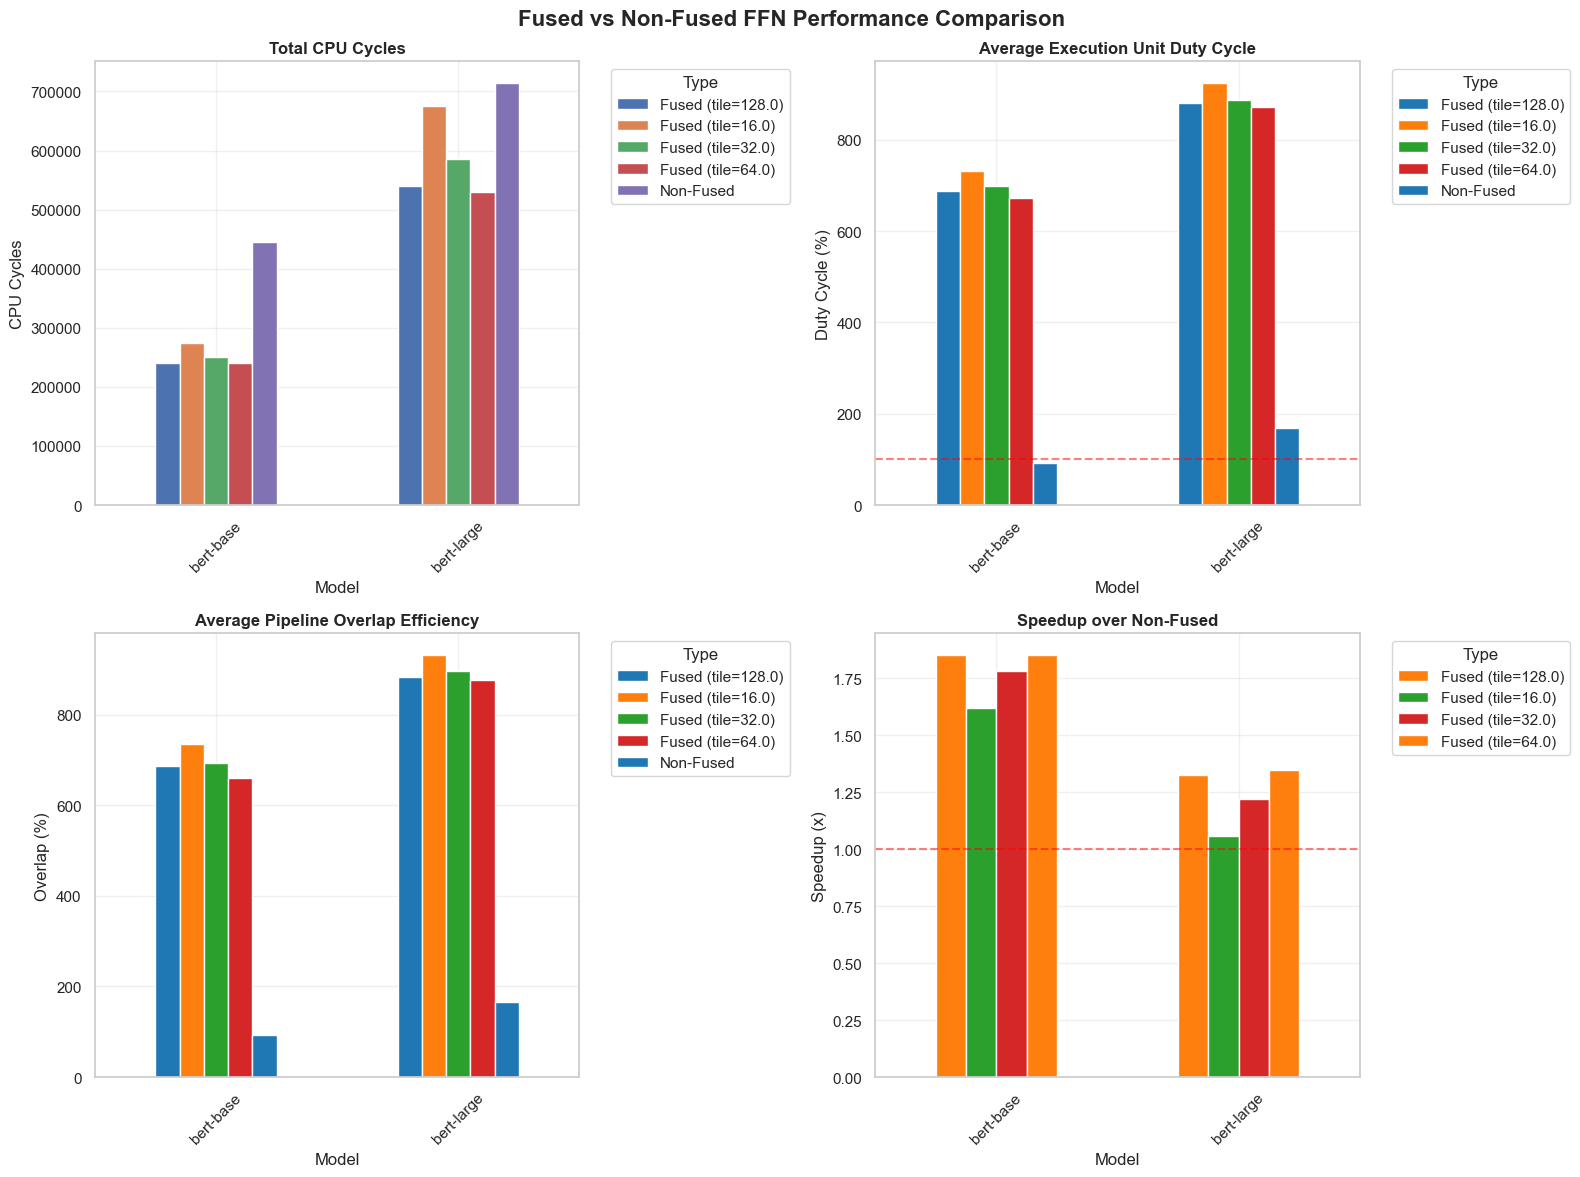

In [44]:
# Create comprehensive comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Fused vs Non-Fused FFN Performance Comparison', fontsize=16, fontweight='bold')

# 1. Total CPU Cycles Comparison
ax1 = axes[0, 0]
comparison_pivot = comparison_table.pivot_table(
    index='Model',
    columns='Type',
    values='Total_CPU_Cycles'
)
comparison_pivot.plot(kind='bar', ax=ax1, rot=45)
ax1.set_title('Total CPU Cycles', fontweight='bold')
ax1.set_ylabel('CPU Cycles')
ax1.set_xlabel('Model')
ax1.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Average Execution Unit Duty Cycle
ax2 = axes[0, 1]
exec_pivot = comparison_table.pivot_table(
    index='Model',
    columns='Type',
    values='Avg_Exec_Duty_%'
)
exec_pivot.plot(kind='bar', ax=ax2, rot=45, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax2.set_title('Average Execution Unit Duty Cycle', fontweight='bold')
ax2.set_ylabel('Duty Cycle (%)')
ax2.set_xlabel('Model')
ax2.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='100%')

# 3. Average Pipeline Overlap Efficiency
ax3 = axes[1, 0]
overlap_pivot = comparison_table.pivot_table(
    index='Model',
    columns='Type',
    values='Avg_Pipeline_Overlap_%'
)
overlap_pivot.plot(kind='bar', ax=ax3, rot=45, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax3.set_title('Average Pipeline Overlap Efficiency', fontweight='bold')
ax3.set_ylabel('Overlap (%)')
ax3.set_xlabel('Model')
ax3.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Speedup over Non-Fused
ax4 = axes[1, 1]
speedup_data = []
for model in comparison_table['Model'].unique():
    model_data = comparison_table[comparison_table['Model'] == model]
    non_fused_cycles = model_data[model_data['Type'] == 'Non-Fused']['Total_CPU_Cycles'].values[0]

    fused_data = model_data[model_data['Type'].str.startswith('Fused')]
    for _, row in fused_data.iterrows():
        speedup = non_fused_cycles / row['Total_CPU_Cycles']
        speedup_data.append({
            'Model': model,
            'Type': row['Type'],
            'Speedup': speedup
        })

speedup_df = pd.DataFrame(speedup_data)
speedup_pivot = speedup_df.pivot_table(index='Model', columns='Type', values='Speedup')
speedup_pivot.plot(kind='bar', ax=ax4, rot=45, color=['#ff7f0e', '#2ca02c', '#d62728'])
ax4.set_title('Speedup over Non-Fused', fontweight='bold')
ax4.set_ylabel('Speedup (x)')
ax4.set_xlabel('Model')
ax4.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Baseline')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Detailed Analysis: Non-Fused Operations by Stage

Now let's examine how different stages perform within the non-fused versions:

In [45]:
# Analyze non-fused operations by stage
non_fused_df = df[df['Log_Type'] == 'Individual Ops'].copy()

# Create detailed table for each model
for model in non_fused_df['Model'].unique():
    model_df = non_fused_df[non_fused_df['Model'] == model].copy()

    print("\n" + "="*120)
    print(f"NON-FUSED OPERATIONS BREAKDOWN: {model}")
    print("="*120)

    # Select relevant columns for display
    display_cols = [
        'Operation',
        'LOAD_ACTIVE_CYCLE', 'STORE_ACTIVE_CYCLE', 'EXE_ACTIVE_CYCLE',
        'MAIN_LD_ST_EX_CYCLES',
        'Load_Duty_Cycle_%', 'Store_Duty_Cycle_%', 'Exec_Duty_Cycle_%',
        'Pipeline_Overlap_%',
        'Load_DMA_Wait_%', 'Exec_Preload_Stall_%'
    ]

    stage_table = model_df[display_cols].copy()
    display(stage_table)

    # Summary statistics
    print(f"\nSummary for {model}:")
    print(f"  Total CPU Cycles: {model_df['CPU_TOTAL_CYCLES'].iloc[0]:,}")
    print(f"  Number of Operations: {len(model_df)}")
    print(f"  Total Load Active Cycles: {model_df['LOAD_ACTIVE_CYCLE'].sum():,}")
    print(f"  Total Store Active Cycles: {model_df['STORE_ACTIVE_CYCLE'].sum():,}")
    print(f"  Total Exec Active Cycles: {model_df['EXE_ACTIVE_CYCLE'].sum():,}")
    print(f"  Average Pipeline Overlap: {model_df['Pipeline_Overlap_%'].mean():.2f}%")
    print(f"  Average Exec Duty Cycle: {model_df['Exec_Duty_Cycle_%'].mean():.2f}%")


NON-FUSED OPERATIONS BREAKDOWN: bert-base


,Operation,LOAD_ACTIVE_CYCLE,STORE_ACTIVE_CYCLE,EXE_ACTIVE_CYCLE,MAIN_LD_ST_EX_CYCLES,Load_Duty_Cycle_%,Store_Duty_Cycle_%,Exec_Duty_Cycle_%,Pipeline_Overlap_%,Load_DMA_Wait_%,Exec_Preload_Stall_%
0,Matmul1+GELU,119623,118682,119788,123743,26.881573,26.670112,26.918652,27.807416,26.285618,27.362247
1,Matmul2,122664,126144,125624,124121,27.564944,28.346966,28.230112,27.892360,27.782472,27.791236
2,LayerNorm,1371994,1371324,1383082,1389863,308.313258,308.162697,310.804944,312.328764,301.204719,306.775506
3,ResAdd,20233,18032,19864,19919,4.546742,4.052135,4.463820,4.476180,4.337079,5.111461



Summary for bert-base:
  Total CPU Cycles: 445,000
  Number of Operations: 4
  Total Load Active Cycles: 1,634,514
  Total Store Active Cycles: 1,634,182
  Total Exec Active Cycles: 1,648,358
  Average Pipeline Overlap: 93.13%
  Average Exec Duty Cycle: 92.60%

NON-FUSED OPERATIONS BREAKDOWN: bert-large


,Operation,LOAD_ACTIVE_CYCLE,STORE_ACTIVE_CYCLE,EXE_ACTIVE_CYCLE,MAIN_LD_ST_EX_CYCLES,Load_Duty_Cycle_%,Store_Duty_Cycle_%,Exec_Duty_Cycle_%,Pipeline_Overlap_%,Load_DMA_Wait_%,Exec_Preload_Stall_%
4,Matmul1+GELU,631848,647381,649765,637135,88.370226,90.542671,90.876097,89.109666,89.893021,90.375958
5,Matmul2,476593,483783,489502,480463,66.656270,67.661863,68.461722,67.197528,66.866480,66.221865
6,LayerNorm,3603137,3569576,3641607,3595792,503.934540,499.240700,509.314952,502.907269,505.168245,500.971327
7,ResAdd,50148,49273,50811,50727,7.013696,6.891319,7.106424,7.094675,7.586982,7.452857



Summary for bert-large:
  Total CPU Cycles: 715,001
  Number of Operations: 4
  Total Load Active Cycles: 4,761,726
  Total Store Active Cycles: 4,750,013
  Total Exec Active Cycles: 4,831,685
  Average Pipeline Overlap: 166.58%
  Average Exec Duty Cycle: 168.94%


## Visualization: Non-Fused Stage Performance

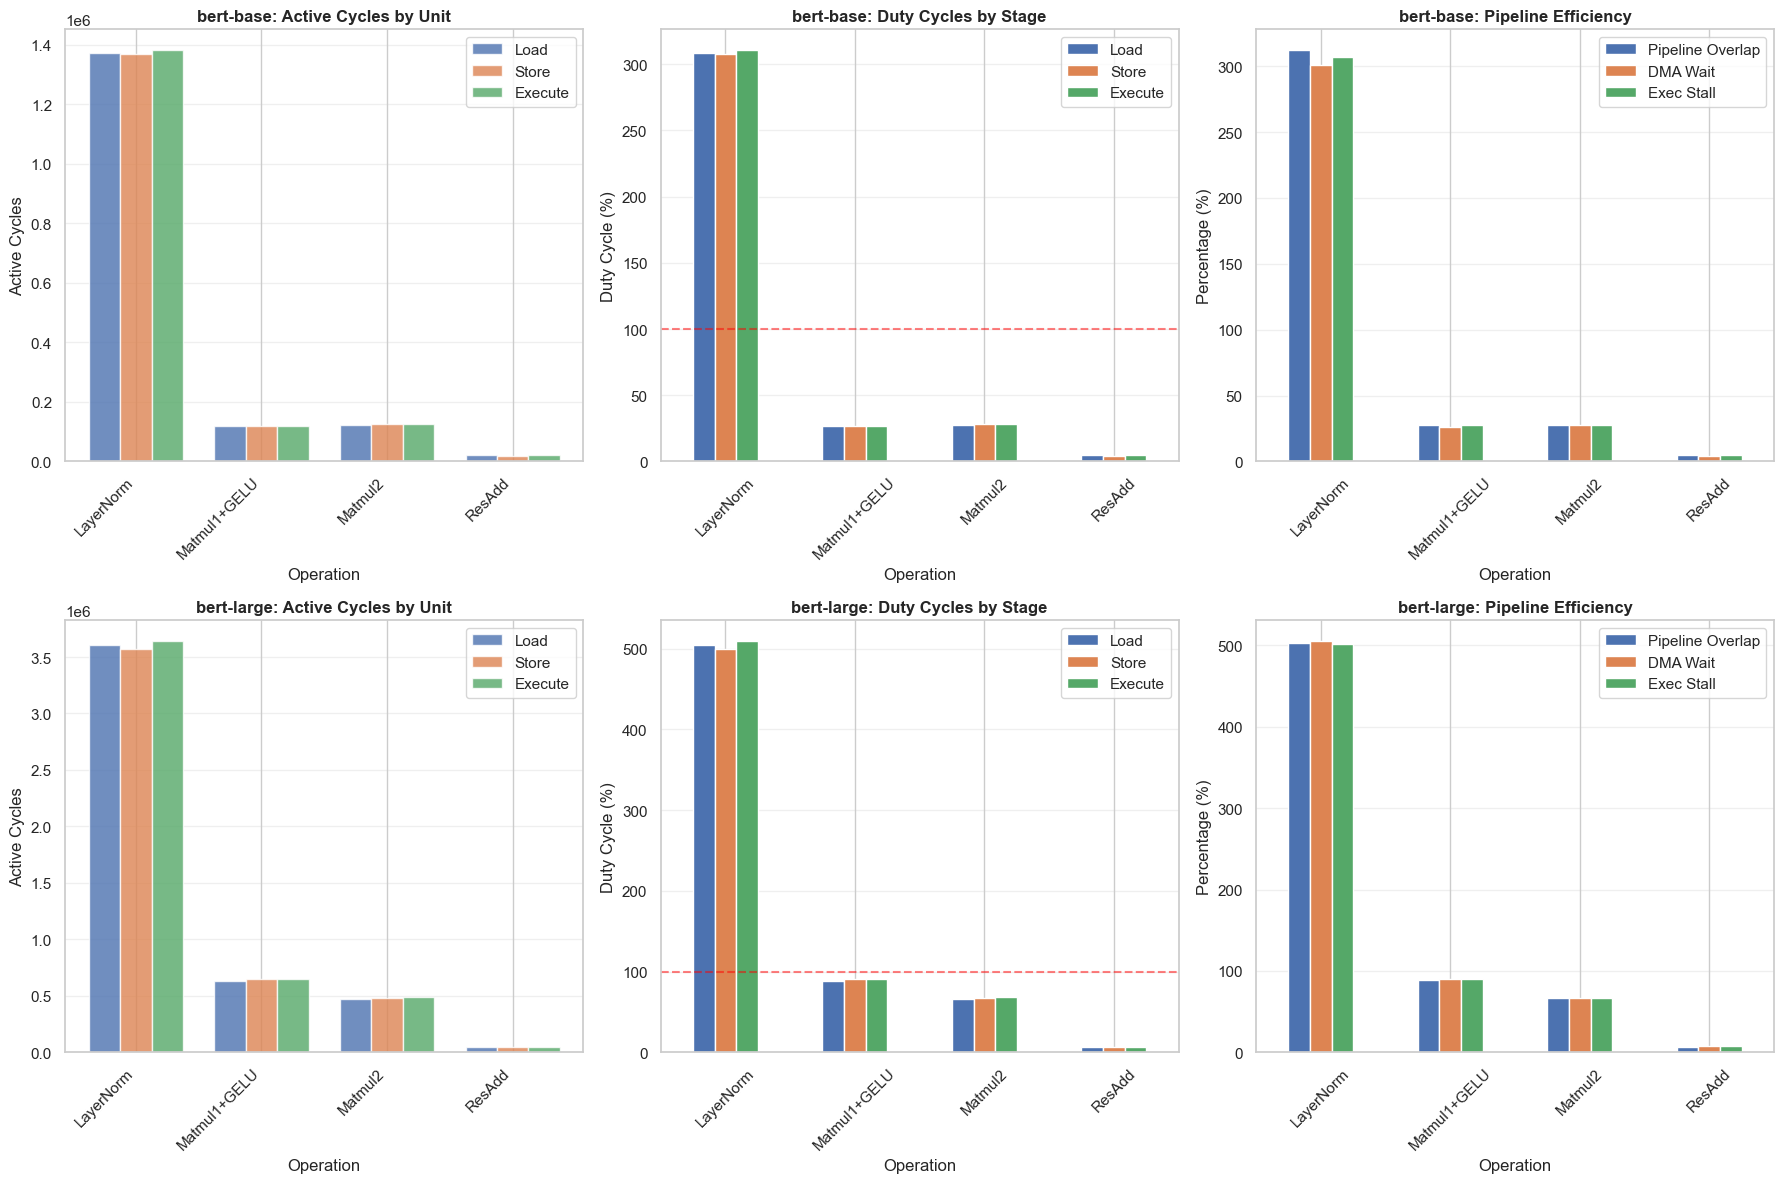

In [46]:
# Visualize non-fused operations by stage
models = non_fused_df['Model'].unique()
n_models = len(models)

fig, axes = plt.subplots(n_models, 3, figsize=(18, 6 * n_models))
if n_models == 1:
    axes = axes.reshape(1, -1)

for idx, model in enumerate(models):
    model_df = non_fused_df[non_fused_df['Model'] == model].copy()

    # Sort by operation for consistent ordering
    model_df = model_df.sort_values('Operation')

    # 1. Active Cycles by Unit
    ax1 = axes[idx, 0]
    x = np.arange(len(model_df))
    width = 0.25

    ax1.bar(x - width, model_df['LOAD_ACTIVE_CYCLE'], width, label='Load', alpha=0.8)
    ax1.bar(x, model_df['STORE_ACTIVE_CYCLE'], width, label='Store', alpha=0.8)
    ax1.bar(x + width, model_df['EXE_ACTIVE_CYCLE'], width, label='Execute', alpha=0.8)

    ax1.set_xlabel('Operation')
    ax1.set_ylabel('Active Cycles')
    ax1.set_title(f'{model}: Active Cycles by Unit', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_df['Operation'], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    # 2. Duty Cycles by Stage
    ax2 = axes[idx, 1]
    duty_data = model_df[['Operation', 'Load_Duty_Cycle_%', 'Store_Duty_Cycle_%', 'Exec_Duty_Cycle_%']].set_index('Operation')
    duty_data.plot(kind='bar', ax=ax2, rot=45)
    ax2.set_title(f'{model}: Duty Cycles by Stage', fontweight='bold')
    ax2.set_ylabel('Duty Cycle (%)')
    ax2.set_xlabel('Operation')
    ax2.legend(['Load', 'Store', 'Execute'])
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.axhline(y=100, color='red', linestyle='--', alpha=0.5)

    # 3. Pipeline Overlap and Stalls
    ax3 = axes[idx, 2]
    overlap_data = model_df[['Operation', 'Pipeline_Overlap_%', 'Load_DMA_Wait_%', 'Exec_Preload_Stall_%']].set_index('Operation')
    overlap_data.plot(kind='bar', ax=ax3, rot=45)
    ax3.set_title(f'{model}: Pipeline Efficiency', fontweight='bold')
    ax3.set_ylabel('Percentage (%)')
    ax3.set_xlabel('Operation')
    ax3.legend(['Pipeline Overlap', 'DMA Wait', 'Exec Stall'])
    ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Stage Contribution Analysis

Analyze what percentage each stage contributes to the total execution:

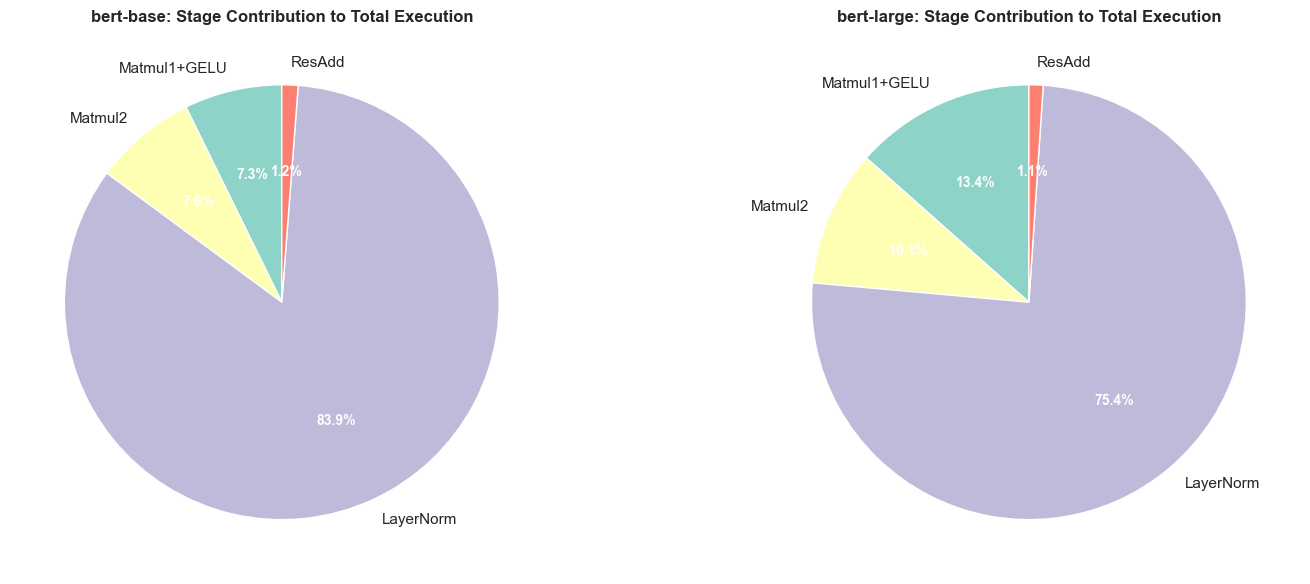


STAGE CONTRIBUTION ANALYSIS

bert-base:
  Total Execution Cycles (sum of all stages): 1,648,358

  Breakdown by operation:
    Matmul1+GELU        :    119,788 cycles (  7.3%)
    Matmul2             :    125,624 cycles (  7.6%)
    LayerNorm           :  1,383,082 cycles ( 83.9%)
    ResAdd              :     19,864 cycles (  1.2%)

bert-large:
  Total Execution Cycles (sum of all stages): 4,831,685

  Breakdown by operation:
    Matmul1+GELU        :    649,765 cycles ( 13.4%)
    Matmul2             :    489,502 cycles ( 10.1%)
    LayerNorm           :  3,641,607 cycles ( 75.4%)
    ResAdd              :     50,811 cycles (  1.1%)


In [47]:
# Analyze stage contribution to total execution
fig, axes = plt.subplots(1, len(models), figsize=(8 * len(models), 6))
if len(models) == 1:
    axes = [axes]

for idx, model in enumerate(models):
    model_df = non_fused_df[non_fused_df['Model'] == model].copy()

    # Calculate contribution percentages based on execution active cycles
    total_exec_cycles = model_df['EXE_ACTIVE_CYCLE'].sum()
    model_df['Exec_Contribution_%'] = (model_df['EXE_ACTIVE_CYCLE'] / total_exec_cycles) * 100

    # Create pie chart
    ax = axes[idx]
    colors = plt.cm.Set3(range(len(model_df)))
    wedges, texts, autotexts = ax.pie(
        model_df['Exec_Contribution_%'],
        labels=model_df['Operation'],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors
    )

    # Make percentage text more readable
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)

    ax.set_title(f'{model}: Stage Contribution to Total Execution', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# Print detailed contribution analysis
print("\n" + "="*120)
print("STAGE CONTRIBUTION ANALYSIS")
print("="*120)

for model in models:
    model_df = non_fused_df[non_fused_df['Model'] == model].copy()
    total_exec = model_df['EXE_ACTIVE_CYCLE'].sum()

    print(f"\n{model}:")
    print(f"  Total Execution Cycles (sum of all stages): {total_exec:,}")
    print(f"\n  Breakdown by operation:")

    for _, row in model_df.iterrows():
        contribution = (row['EXE_ACTIVE_CYCLE'] / total_exec) * 100
        print(f"    {row['Operation']:20s}: {row['EXE_ACTIVE_CYCLE']:10,} cycles ({contribution:5.1f}%)")